## Analysis of model coefficients

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
results_dir = '/home/jake/data/pancancer_vogelstein_09_25'
pancancer_dir = os.path.join(results_dir, 'pancancer')
single_cancer_dir = os.path.join(results_dir, 'single_cancer')

In [3]:
sample_info_df = du.load_sample_info()
tcga_cancer_types = list(np.unique(sample_info_df.cancer_type))

identifier_coefs_info = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        cancer_covs = au.get_cancer_type_covariates(coefs, tcga_cancer_types)
        identifier_coefs_info.append((identifier, fold_no, len(cancer_covs), cancer_covs))
        
# TODO: do we need a way to generate list of all features?
ids_df = pd.DataFrame(identifier_coefs_info, columns=['identifier', 'fold', 'nz_cov_count', 'nz_covs'])
ids_df[ids_df.nz_cov_count > 0].head(n=10)

,identifier,fold,nz_cov_count,nz_covs
12,MLH1_UCEC,0,1,[UCEC]
14,MLH1_UCEC,2,1,[UCEC]
196,BRCA1_BLCA,0,1,[UCEC]
197,BRCA1_BLCA,1,1,[UCEC]
245,CBL_UCEC,1,1,[UCEC]
246,CBL_UCEC,2,1,[UCEC]
247,CBL_UCEC,3,1,[UCEC]
268,GNA11_UVM,0,1,[UVM]
295,MAP2K1_SKCM,3,1,[SKCM]
304,MET_LUAD,0,1,[UCEC]


In [4]:
# load significant identifiers and join into coefficients dataframe
pancancer_comparison_df = pd.read_csv(os.path.join(results_dir, 'pancancer_pvals.tsv'),
                                      index_col=False, sep='\t')
merge_df = (
    ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
          .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
merge_df.head(n=8)

,identifier,fold,nz_cov_count,nz_covs,reject_null
0,MAP3K1_BRCA,0,0,[],True
1,MAP3K1_BRCA,1,0,[],True
2,MAP3K1_BRCA,2,0,[],True
3,MAP3K1_BRCA,3,0,[],True
4,MAP3K1_COAD,0,0,[],False
5,MAP3K1_COAD,1,0,[],False
6,MAP3K1_COAD,2,0,[],False
7,MAP3K1_COAD,3,0,[],False


Text(0, 0.5, 'Number of models (fold/cancer type/gene)')

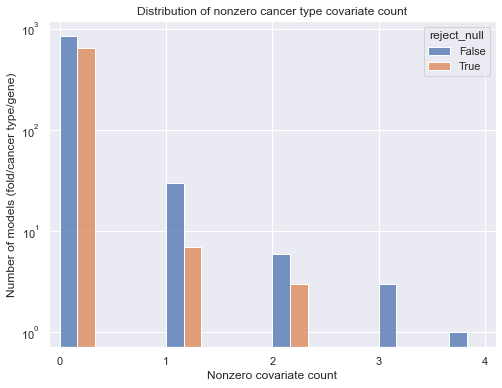

In [6]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=merge_df, x='nz_cov_count', hue='reject_null', log_scale=(False, True),
             kde=False, multiple='dodge')
plt.xticks(range(0, 5))
plt.xlim(-0.1, 4.1)
plt.title('Distribution of nonzero cancer type covariate count')
plt.xlabel('Nonzero covariate count')
plt.ylabel('Number of models (fold/cancer type/gene)')